In [2]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.warp import transform, reproject, Resampling
from rasterio.mask import mask as rio_mask
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from shop.plotting.plotting_fxns import *

colors = ['#63c4c7','#fcc02e','#4D559C','#60C252','#BF1F6A',
              '#F77808','#298282','#999999','#FF89B0','#427801']

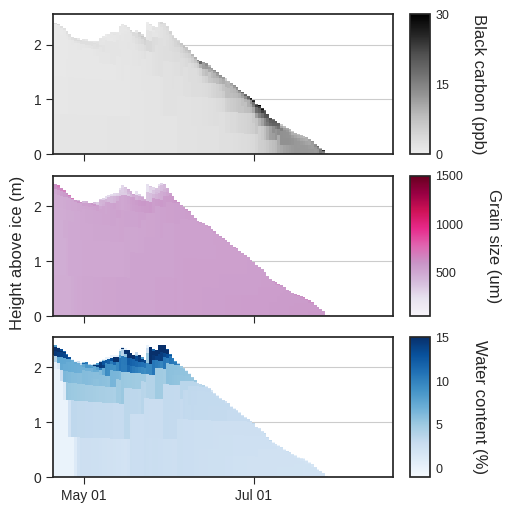

(<Figure size 500x510 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

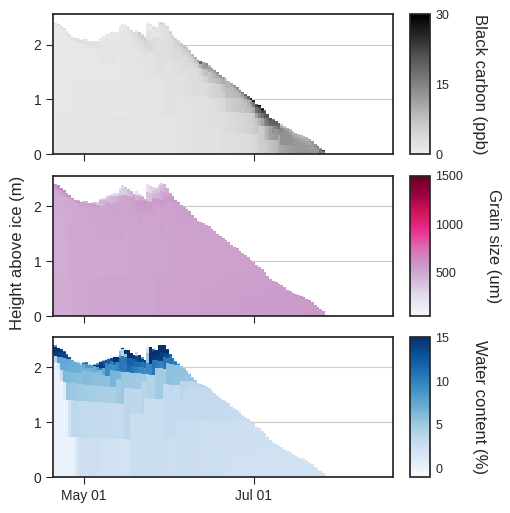

In [24]:
dates = pd.date_range('2024-04-20','2024-08-20')

ds_good = xr.open_dataset('../Output/gulkanaB_2025_12_04_1.nc')
visualize_layers(ds, dates, ['layerBC','layergrainsize','layerwater'])
plt.show()
ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaB_2025_12_04_base_long_0.nc')
visualize_layers(ds, dates, ['layerBC','layergrainsize','layerwater'])

In [25]:
ds = xr.open_dataset('../Output/gulkanaB_2025_12_04_1.nc')
snow_grains = ds['layergrainsize'].where(ds['layertype'] == 0)
print(snow_grains.max())

<xarray.DataArray 'layergrainsize' ()> Size: 8B
array(729.16053775)


In [7]:
albedo_fp = '/trace/group/rounce/cvwilson/gulkana_albedo/albedo/'
mask_fp = '/trace/group/rounce/cvwilson/gulkana_masks/masks/'
dem_fp = '/trace/home/cvwilson/research/data/dems/gulkana_dem.tif'
shp_fp = '/trace/group/rounce/cvwilson/dems/gulkana_shapefile.shp'

In [8]:
df_points = pd.read_csv('data/by_glacier/gulkana/site_constants.csv', index_col=0)
sites = ['AU','AB','B','D','T','Z']

In [9]:
df = pd.DataFrame({f'albedo_rs_{site}':[] for site in sites}, index=[])

albedo_files = os.listdir(albedo_fp)
mask_files = os.listdir(mask_fp)
for fmask, falbedo in zip(mask_files, albedo_files):
    with rasterio.open(albedo_fp + falbedo) as albedo_ds, rasterio.open(mask_fp + fmask) as mask_ds:
        src_crs = "EPSG:4326"
        dst_crs = albedo_ds.crs
        date = pd.to_datetime(falbedo[:8])

        for site in sites:
            lat = df_points.loc[site, 'lat']
            lon = df_points.loc[site, 'lon']
            x, y = transform(src_crs, dst_crs, [lon], [lat])

            # Convert map coords to row/col
            row, col = albedo_ds.index(x[0], y[0])

            # Read pixel values
            albedo_val = albedo_ds.read(1)[row, col]
            no_clouds = bool(mask_ds.read(1)[row, col])
            # 1 = clear (True), 0 = cloudy (False)

            # Apply cloud mask logic
            if no_clouds:
                df.loc[date, f'albedo_rs_{site}'] = albedo_val 

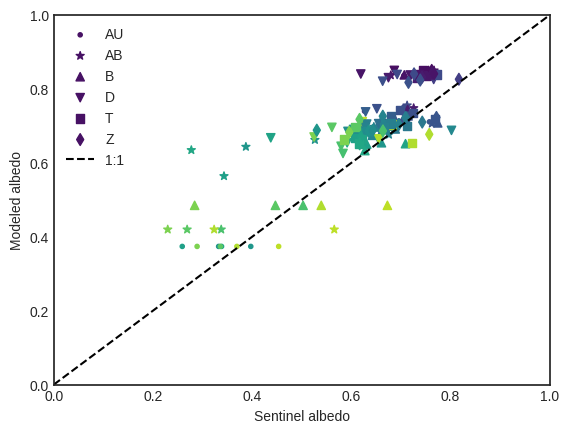

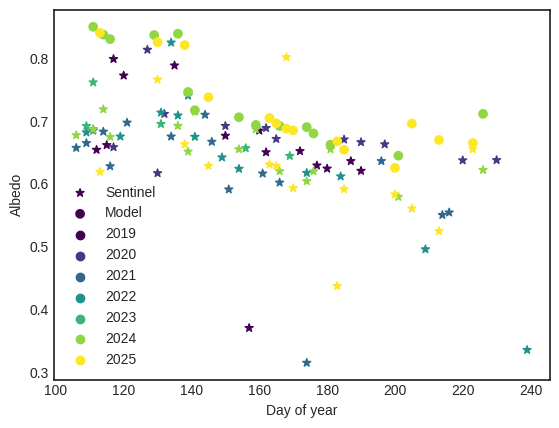

In [6]:
fn ='/trace/group/rounce/cvwilson/Output/gulkanaSITE_2025_12_05_base_short_0.nc'
# fn = '/trace/group/rounce/cvwilson/Output/08_01_SITE_0/grid_08_01_set67_run0_0.nc'
# df = df.loc[slice('2024-01-01','2024-10-01')]

cmap = plt.colormaps.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=np.min(df.index.day_of_year), vmax=np.max(df.index.day_of_year))
markers = ['.','*','^','v','s','d']

sites = sites
for site in sites:
    ds = xr.open_dataset(fn.replace('SITE', site))
    list_modeled = []
    colors = []
    for date in df.index:
        colors.append(cmap(norm(date.day_of_year)))
        if date in ds.time.values:
            albedo_mod = ds.albedo.sel(time=date).values 
            list_modeled.append(albedo_mod)
        else:
            list_modeled.append(np.nan)

    df[f'albedo_mod_{site}'] = list_modeled 

fig, ax = plt.subplots()
for si, site in enumerate(sites):
    ax.scatter(df[f'albedo_rs_{site}'], df[f'albedo_mod_{site}'], color=colors, marker=markers[si], label=site)
ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='1:1')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Sentinel albedo')
ax.set_ylabel('Modeled albedo')
plt.show()

fig, ax = plt.subplots()
cmap = plt.colormaps.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=np.min(df.index.year), vmax=np.max(df.index.year))
for site in ['D']:
    ax.scatter(df.index.day_of_year, df[f'albedo_rs_{site}'], color=cmap(norm(df.index.year)), marker='*', label='Sentinel')
    ax.scatter(df.index.day_of_year, df[f'albedo_mod_{site}'], color=cmap(norm(df.index.year)), label='Model')
for year in np.unique(df.index.year):
    ax.scatter(np.nan, np.nan, color=cmap(norm(year)), label=str(year))
ax.set_ylabel('Albedo')
# ax.set_xlim(df.index[0], df.index[-1])
ax.set_xlabel('Day of year')
ax.legend()
plt.show()

In [ ]:
# dsd = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaD_2025_12_04_base_long_1.nc')

# dsd = dsd.sel(time=pd.to_datetime('2024-08-10'))
# print(dsd.layergrainsize.isel(layer=[0,1,2,3]).values)
# print(dsd.layerBC.isel(layer=[0,1,2,3]).values)
# print(dsd.layerdust.isel(layer=[0,1,2,3]).values)
# print(dsd.albedo.values)
# plt.plot(dsd.time, dsd.albedo)
# plt.plot(dsd.time, dsd.layergrainsize.isel(layer=0))

(np.float64(0.24165531967211665), np.float64(0.4346140199825338), np.float64(0.5947504752548162))


(<Figure size 640x480 with 1 Axes>,
 <Axes: ylabel='Seasonal mass balance (m w.e.)'>)

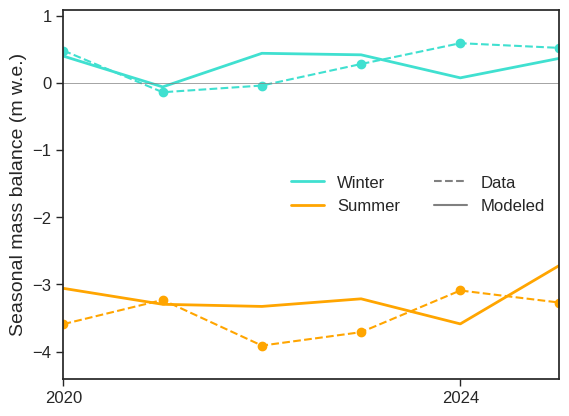

In [70]:
from objectives import * 
ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaAU_2025_12_05_base_long_0.nc')
print(seasonal_mass_balance(ds))
plot_seasonal_mass_balance(ds)

(0.0, 1000.0)

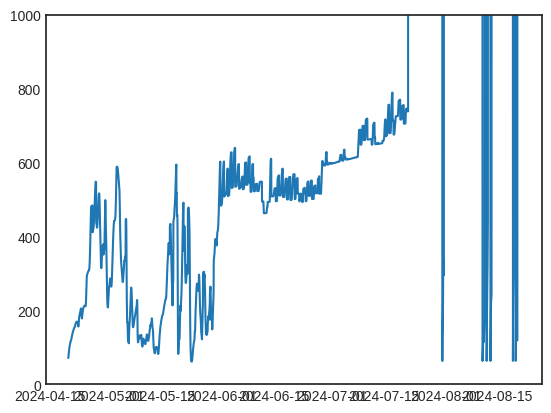

In [5]:
ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaB_2025_12_05_base_short_2.nc')
ds24 = ds.sel(time=slice('2024-04-20','2024-08-20'))
plt.plot(ds24.time, ds24.layergrainsize.isel(layer=0))
plt.ylim(0, 1000)

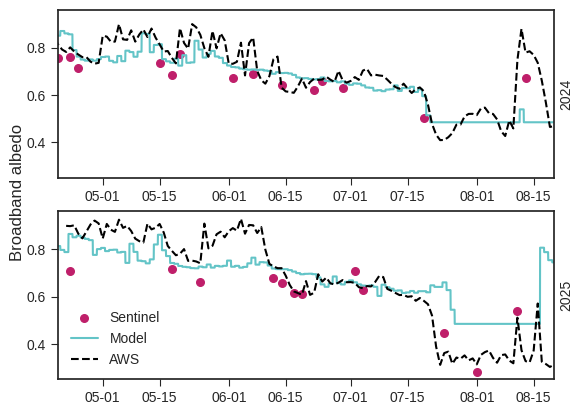

In [12]:
fig, (ax1, ax2) = plt.subplots(2,sharey=True)
site = 'B'

rs_2024 = df.loc[df.index.year == 2024]
ax1.scatter(rs_2024.index, rs_2024[f'albedo_rs_{site}'], color=colors[4], s=30, label='Sentinel')
rs_2025 = df.loc[df.index.year == 2025]
ax2.scatter(rs_2025.index, rs_2025[f'albedo_rs_{site}'], color=colors[4], s=30, label='Sentinel')

ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaB_2025_12_05_base_short_7.nc')
# ds = xr.open_dataset('../Output/gulkanaB_2025_12_05_2.nc')
# ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaB_2025_12_04_base_long_1.nc')
ds24 = ds.sel(time=slice('2024-04-20','2024-08-20'))
ax1.plot(ds24.time, ds24.albedo,c=colors[0])

# ds = xr.open_dataset('../Output/gulkanaB_2025_12_05_0.nc')
# # ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaB_2025_12_04_base_long_1.nc')
# ds = ds.sel(time=slice('2024-04-20','2024-08-20'))
# plt.plot(ds.time, ds.albedo)

df24 = pd.read_csv('../climate_data/AWS/Processed/gulkana/gulkana2024_walbedo.csv',parse_dates=True, index_col=0)

df24 = df24.resample('d').mean()
ax1.plot(df24.index, df24['albedo'], c='k', linestyle='--',label='AWS')

# ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaB_2025_12_04_base_long_1.nc')
ds25 = ds.sel(time=slice('2025-04-20','2025-08-20'))
ax2.plot(ds25.time, ds25.albedo,c=colors[0], label='Model')

df25 = pd.read_csv('../climate_data/AWS/Processed/gulkana/gulkanaB2025walbedo.csv',parse_dates=True, index_col=0)

df25 = df25.resample('d').mean()
ax2.plot(df25.index, df25['albedo'], c='k', linestyle='--',label='AWS')
for ax in [ax1, ax2]:
    ax.tick_params(length=5)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
    title = '2024' if ax == ax1 else '2025'
    ax.set_xlim(pd.to_datetime(f'{title}-04-20'), pd.to_datetime(f'{title}-08-20'))
    ax.set_ylabel(title)
    ax.yaxis.set_label_position('right')
ax.legend()
fig.supylabel('Broadband albedo', x=0.05)
plt.show()


In [34]:
with rasterio.open(dem_fp) as dem_src:
    dem_data = dem_src.read(1)
    dem_profile = dem_src.profile
dem = rasterio.open(dem_fp)

shp = gpd.read_file(shp_fp)

df = pd.DataFrame({f'albedo_rs_{site}':[] for site in sites}, index=[])
min_elev = int(np.nanmin(dem_data) // 100 * 100)
max_elev = int(np.nanmax(dem_data) // 100 * 100 + 100)
bins = np.arange(min_elev, max_elev + 100, 100)

# Labels for DataFrame columns
bin_labels = bins[:-1]
df = pd.DataFrame(columns=bin_labels)

albedo_files = os.listdir(albedo_fp)
masks = os.listdir(mask_fp)
for fmask, falbedo in zip(masks, albedo_files):
    with rasterio.open(albedo_fp + falbedo) as albedo, rasterio.open(mask_fp + fmask) as mask:
        # if fmask == masks[0]:
        #     dem_resampled = np.empty((albedo.height, albedo.width), dtype=np.float32)
        #     reproject(
        #         source=dem_data,
        #         destination=dem_resampled,
        #         src_transform=dem_profile['transform'],
        #         src_crs=dem_profile['crs'],
        #         dst_transform=albedo.transform,
        #         dst_crs=albedo.crs,
        #         resampling=Resampling.bilinear
        #     )

        date = pd.to_datetime(falbedo[:8])

        # clip albedo to the shapefile
        shp_proj = shp.to_crs(albedo.crs)
        geom = [shp_proj.union_all().__geo_interface__]
        albedo_clipped, albedo_transform = rio_mask(albedo, geom, crop=True)
        albedo_arr = albedo_clipped[0].astype(float)

        # Reproject mask into albedo grid, then clip
        mask_clipped, mask_transform = rio_mask(mask, geom, crop=True)
        mask_arr = mask_clipped[0].astype(float)
        mask_resampled = np.empty(albedo_arr.shape, dtype=np.float32)
        reproject(
            source=mask_arr,
            destination=mask_resampled,
            src_transform=mask_transform,
            src_crs=mask.crs,
            dst_transform=albedo_transform,
            dst_crs=albedo.crs,
            resampling=Resampling.nearest
        )

        if fmask == masks[0]:
            # Clip mask and dem to shapefile
            dem_clipped, dem_transform = rio_mask(dem, geom, crop=True)
            dem_arr = dem_clipped[0].astype(float)
            dem_resampled = np.empty(albedo_arr.shape, dtype=np.float32)
            reproject(
                source=dem_arr,
                destination=dem_resampled,
                src_transform=dem_transform,
                src_crs=dem.crs,
                dst_transform=albedo_transform,
                dst_crs=albedo.crs,
                resampling=Resampling.nearest
            )

        # Apply cloud mask (1=clear, 0=cloudy)
        albedo_arr = np.where(mask_resampled == 1.0, albedo_arr, np.nan)

        # Bin by elevation
        bin_indices = np.digitize(dem_resampled, bins) - 1

        # Aggregate mean albedo per bin
        bin_means = []
        for i, label in enumerate(bin_labels):
            vals = albedo_arr[bin_indices == i]
            if vals.size > 0 and np.any(~np.isnan(vals)):
                bin_means.append(np.nanmean(vals))
            else:
                bin_means.append(np.nan)

        # Use date from filename
        date = pd.to_datetime(falbedo[:8])  # assumes YYYYMMDD prefix
        df.loc[date] = bin_means
df

,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400
2019-04-22,NaN,0.767983,0.761269,0.755852,0.738679,0.712686,0.715258,0.723021,0.711840,0.715881,0.740095,0.739119,0.739276,0.559717
2019-04-25,NaN,0.814119,0.797026,0.837298,0.871578,0.847649,0.829948,0.826475,0.822273,0.852342,0.862237,0.773696,0.704457,0.500420
2019-04-27,NaN,0.783247,0.762350,0.760062,0.755297,0.738754,0.771291,0.834173,0.799804,0.835380,0.840779,0.760181,0.677922,0.501523
2019-04-30,NaN,0.719419,0.700734,0.699813,0.700443,0.689696,0.697699,0.746771,0.713953,0.722619,0.703375,0.680285,0.577522,0.405329
2019-05-15,NaN,0.630014,0.640478,0.677143,0.673402,0.657407,0.684260,0.724156,0.692157,0.690834,0.672984,0.650568,0.611312,0.498295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-04,NaN,0.187957,0.223380,0.267368,0.438229,0.575986,0.592671,0.624493,0.615261,0.617559,0.614392,0.632193,0.653627,0.566817
2025-07-19,NaN,NaN,NaN,0.355202,0.353259,0.524178,0.561756,0.614663,0.603119,0.639683,0.624725,0.614679,0.588644,0.510485
2025-07-24,NaN,0.144207,0.181146,0.225871,0.262228,0.392771,0.503089,0.572916,0.581235,0.588265,0.567497,0.578735,0.570108,0.506359
2025-08-01,NaN,0.136116,0.167552,0.203277,0.221151,0.289712,0.411236,0.520511,0.553451,0.564759,0.534565,0.529463,0.498190,0.436306


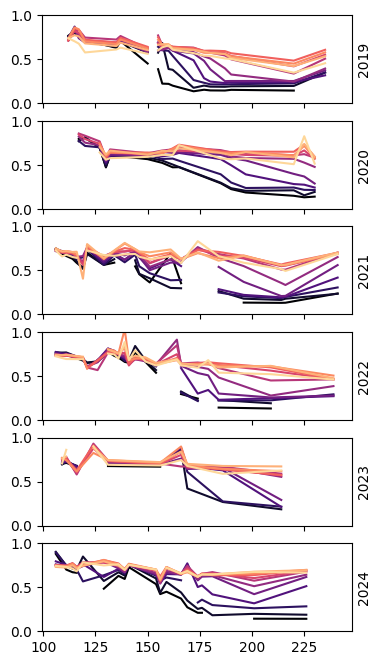

In [44]:
df_2024 = df.loc[slice('2024-01-01','2024-10-01')]
cmap = plt.get_cmap('magma')
norm = mpl.colors.Normalize(vmin=1200, vmax=2400)

fig, axes = plt.subplots(6, sharey=True, sharex=True, figsize=(4, 8)) # , gridspec_kw={'hspace':0}
for ax, year in zip(axes, np.arange(2019, 2025)):
    df_year = df.loc[slice(f'{year}-01-01', f'{year}-11-01')]
    for ci, col in enumerate(df.columns[:-1]):
        ax.plot(df_year.index.day_of_year, df_year[col], color=cmap(norm(int(col))), label=col)
    ax.set_ylabel(str(year))
    ax.yaxis.set_label_position('right')
ax.set_ylim(0, 1)
# axes[0].legend()
plt.show()

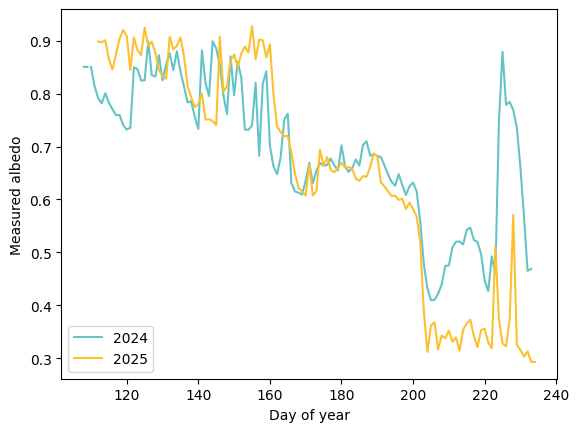

In [23]:
df_2024 = pd.read_csv('../climate_data/AWS/Processed/gulkana/gulkana2024_walbedo.csv', index_col=0, parse_dates=True)
df_2025 = pd.read_csv('../climate_data/AWS/Processed/gulkana/gulkanaB2025walbedo.csv', index_col=0, parse_dates=True)

plt.plot(df_2024.index.day_of_year, df_2024.albedo, color=colors[0], label='2024')
plt.plot(df_2025.index.day_of_year, df_2025.albedo, color=colors[1], label='2025')
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Measured albedo')
plt.show()